In [1]:
import re
import pandas as pd
import numpy as np
import pymorphy2  # Морфологический анализатор
import nltk
import matplotlib.pyplot as plt

from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")
target = pd.read_csv("users_churn.csv")

stopword_ru = stopwords.words('russian')

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords


$$\text{Cleaning and Lemmatization}$$

In [3]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''
    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

$$\text{Vector LDA}$$

In [4]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple])) #словарь {topic: prob}
    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

$$\text{Embedding}$$

In [5]:
def get_user_embedding(user_articles_list, doc_dict, estimate = 'mean', df_idf = None):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if estimate == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif estimate == 'median':
        user_vector = np.median(user_vector, 0)
    elif estimate == 'max':
        user_vector = np.max(user_vector, 0)
    elif estimate == 'idf':
        weights = [df_idf.loc[df_idf['doc_id'] == doc_id, 'doc_idf'].values for doc_id in user_articles_list]
        tmp_user_vector = 0
        for w, v in zip(weights, user_vector):
            tmp_user_vector += w * v
        user_vector = tmp_user_vector
    return user_vector

$$\text{Plot Confusion Matrix}$$

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Очистка текста
news['title'] = news['title'].apply(lambda x: clean_text(x))

In [8]:
# Лемматизацию текста
news['title'] = news['title'].apply(lambda x: lemmatization(x))

In [9]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:
N_topic = 20
# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

In [ ]:
# x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
# topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# # Самые популярные слова в темах
# for topic, words in topics_words:
#     print(f"topic_{topic}: " + " ".join(words))

In [11]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]

In [12]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [39]:
#user embending
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, 'max'))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

In [40]:
X = pd.merge(user_embeddings, target, 'left')

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [182]:
clf = LogisticRegression(max_iter = 200)
clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)[:, 1]
y_test_pred = clf.predict_proba(X_test)[:, 1]

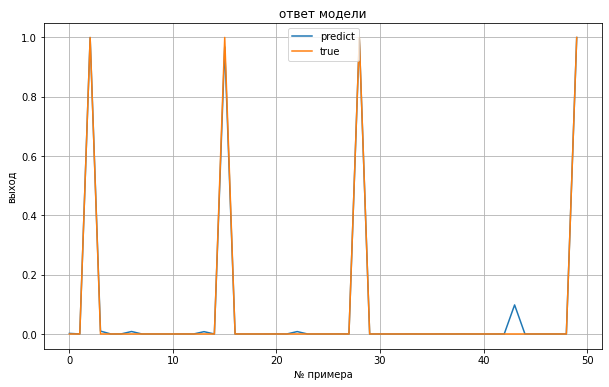

In [183]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(y_test_pred[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [184]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
precision, recall = precision[:-1], recall[:-1]

nzm_prec = precision != 0
nzm_rec = recall != 0
nzm = nzm_prec * nzm_rec

precision, recall, thresholds = precision[nzm], recall[nzm], thresholds[nzm]

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.571, F-Score=1.000, Precision=1.000, Recall=1.000


Confusion matrix, without normalization
[[1755    0]
 [   1  244]]


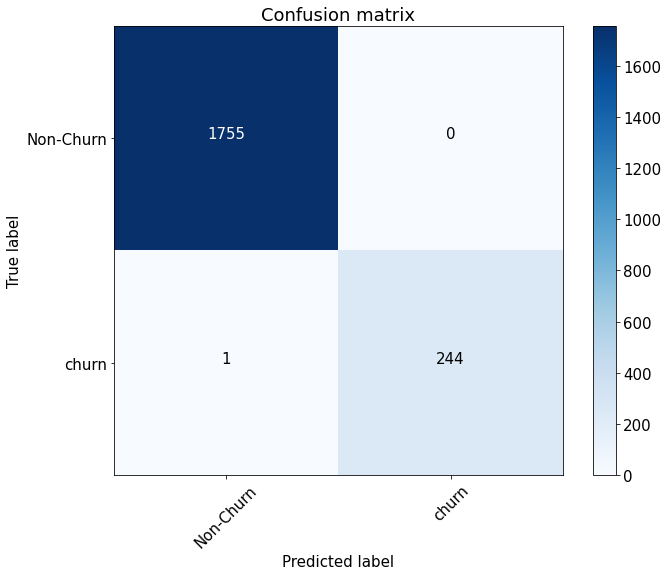

In [185]:
import itertools
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_test_pred > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [186]:
roc_auc_score(y_test, y_test_pred)

1.0

In [93]:
#axis = 0 — столбец
#axis = 1 — строка

### Task №4

* Сначала нужно получить $idf$ для каждого документа. Получим все значения $idf$ внутри одного документа, а $idf$-документа возьмем как среднее от $idf$-слов в этом документе.

In [18]:
def get_docs_idf(news):
    max_features = 300
    df_idf = pd.DataFrame({'doc_id': news['doc_id'].values}, columns = ['doc_id', 'doc_idf'])
    for doc_id, doc in news[['doc_id', 'title']].values:
        tf = TfidfVectorizer(stop_words='english', max_features=max_features)
        tf.fit(doc)
        df_idf.loc[df_idf['doc_id'] == doc_id, 'doc_idf'] = tf.idf_.mean()
        
    return df_idf
        

In [19]:
# df_idf = get_docs_idf(news)
# df_idf.to_csv('df_idf')

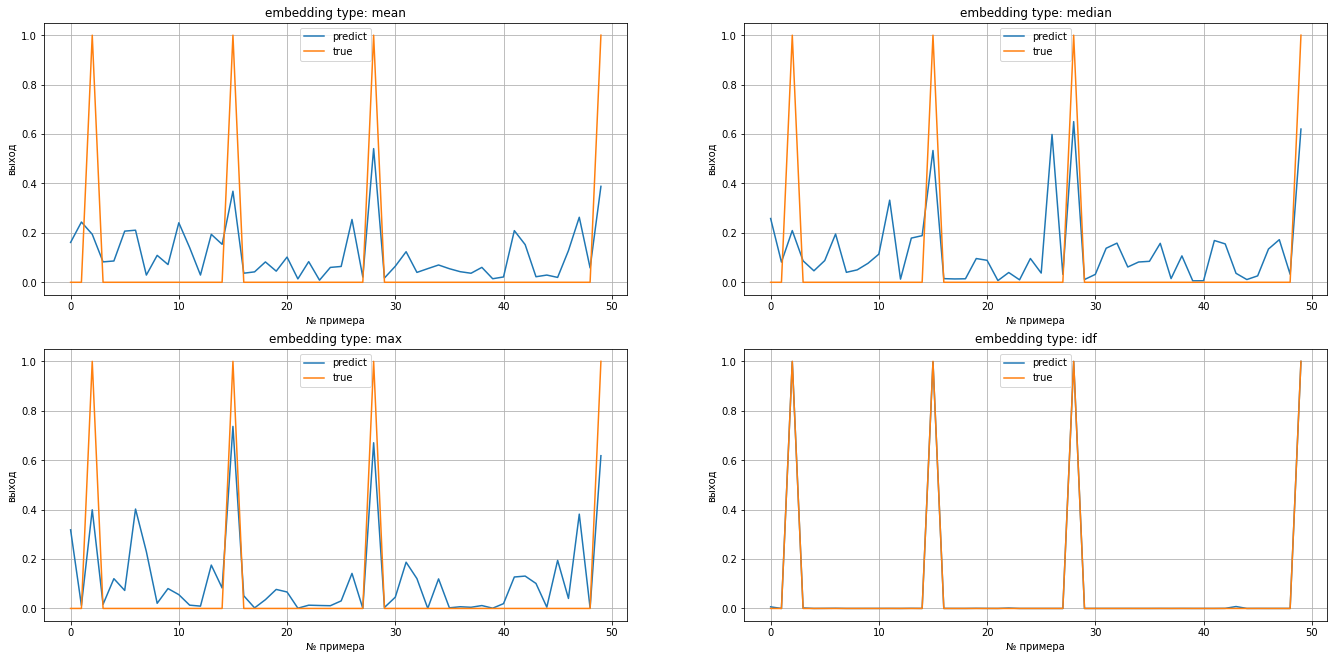

In [42]:
df_idf = pd.read_csv('df_idf')
emb_type = ['mean', 'median', 'max', 'idf']
t_list, f_list, p_list, r_list, roc_list = [], [], [], [], []

fig, ax = plt.subplots(2, 2, figsize = (23, 11))
ax = ax.ravel()
k = 0

for emb in emb_type:
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, emb, df_idf))])
    user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)
    clf = LogisticRegression(max_iter = 200)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:, 1]
    
    ax[k].plot(y_test_pred[:50], label = 'predict')
    ax[k].plot(y_test.values[:50], label = 'true')
    ax[k].set_title(f'embedding type: {emb}')
    ax[k].set_xlabel('№ примера')
    ax[k].set_ylabel('выход')
    ax[k].legend()
    ax[k].grid()
    
    k += 1
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
    precision, recall = precision[:-1], recall[:-1]

    nzm_prec = precision != 0
    nzm_rec = recall != 0
    nzm = nzm_prec * nzm_rec

    precision, recall, thresholds = precision[nzm], recall[nzm], thresholds[nzm]

    fscore = (2 * precision * recall) / (precision + recall)

    ix = np.argmax(fscore)
    t_list.append(thresholds[ix])
    f_list.append(fscore[ix]) 
    p_list.append(precision[ix])
    r_list.append(recall[ix])
    roc_list.append(roc_auc_score(y_test, y_test_pred))
   

In [43]:
results = pd.DataFrame({'Threshold': t_list,
                        'F-score': f_list,
                        'Precision': p_list,
                        'Recall': r_list,
                        'ROC-AUC': roc_list}, index = ['mean', 'median', 'max', 'idf'], columns = ['Threshold', 'F-score', 'Precision', 'Recall', 'ROC-AUC'])

results

,Threshold,F-score,Precision,Recall,ROC-AUC
mean,0.221987,0.601266,0.490956,0.775510,0.923249
median,0.278951,0.656716,0.604811,0.718367,0.941825
max,0.365962,0.710638,0.742222,0.681633,0.955614
idf,0.848105,1.000000,1.000000,1.000000,1.000000
